In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
valid_size = .2
batch_size = 16
num_workers = 2
classes = ["Real", "Fake"]

train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.ToTensor(),
                               transforms.Normalize([.485, .456, .406], [.229, .224, .225])])

test_transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                               transforms.Normalize([.485, .456, .406], [.229, .224, .225])])

train_dataset = datasets.ImageFolder("./progan_train/horse/", transform=train_transform)
test_dataset = datasets.ImageFolder("./CNN_synth_testset/progan/horse/", transform=test_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                               num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

class_names = train_dataset.classes


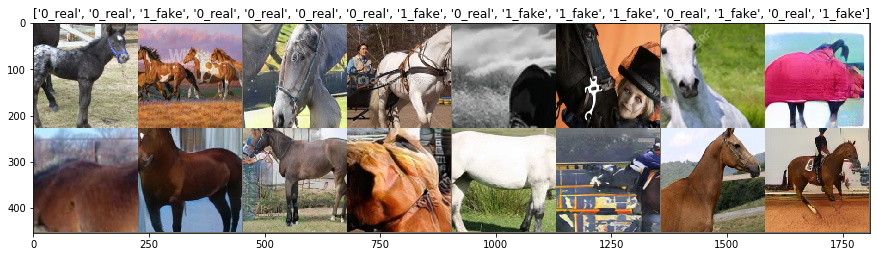

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


plt.figure(figsize=(15,15))
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
resnet = models.resnet18(pretrained=True)

model = nn.Sequential(resnet, nn.Linear(1000, 2))
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = .9)
criterion = nn.CrossEntropyLoss()

0.1

In [5]:
num_epochs = 2
since = time.time()
print_every_n_batches = 200
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    #running_corrects = 0
    
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        #_, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        #running_corrects += torch.sum(preds == labels.data)
        
        if i % print_every_n_batches == print_every_n_batches - 1:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every_n_batches), end = " ")
            losses.append(running_loss / print_every_n_batches)
            running_loss = 0.0
            
    
            time_elapsed = time.time() - since
            print(f'Time elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Epoch 1/2
----------
[1,   200] loss: 0.876 Time elapsed: 0m 8s
[1,   400] loss: 0.680 Time elapsed: 0m 16s
[1,   600] loss: 0.404 Time elapsed: 0m 23s
[1,   800] loss: 0.264 Time elapsed: 0m 31s
[1,  1000] loss: 0.231 Time elapsed: 0m 39s
[1,  1200] loss: 0.214 Time elapsed: 0m 46s
[1,  1400] loss: 0.176 Time elapsed: 0m 54s
[1,  1600] loss: 0.168 Time elapsed: 1m 2s
[1,  1800] loss: 0.143 Time elapsed: 1m 10s
Epoch 2/2
----------
[2,   200] loss: 0.116 Time elapsed: 1m 18s
[2,   400] loss: 0.103 Time elapsed: 1m 26s
[2,   600] loss: 0.118 Time elapsed: 1m 34s
[2,   800] loss: 0.112 Time elapsed: 1m 42s
[2,  1000] loss: 0.091 Time elapsed: 1m 50s
[2,  1200] loss: 0.113 Time elapsed: 1m 57s
[2,  1400] loss: 0.094 Time elapsed: 2m 5s
[2,  1600] loss: 0.075 Time elapsed: 2m 13s
[2,  1800] loss: 0.079 Time elapsed: 2m 20s
Training complete in 2m 20s


In [6]:
n = 0
acc = torch.tensor(0).to(device)
for data in valid_loader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    y_pred = torch.argmax(model.forward(inputs), 1) 
    acc = torch.add(acc, torch.sum(y_pred == labels))
    n += len(labels)
    
acc / float(n)

tensor(0.9420, device='cuda:0')

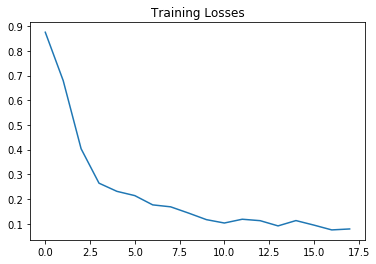

In [7]:
plt.title("Training Losses")
plt.plot(losses)